In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob
import cv2
import skimage
from imageio import imread
import csv
import math
import ktrain
from keras_lr_finder import LRFinder
import sys

In [2]:
sys.path.insert(1, '/home/houcem/git/CLR')

In [3]:
from clr_callback import *

# Creating a generator to load and preprocess the images

In [4]:
train_csv_path = "/home/houcem/data/combined_csv.csv"
val_csv_path = "/home/houcem/data_val/data.csv"
train_sample_size = sum(1 for row in open(train_csv_path))
val_sample_size = sum(1 for row in open(val_csv_path))
path = "/home/houcem/data/data.csv"

In [5]:
batch_size = 50

In [6]:
def generator(csv_path, batch_size):
    X_train = []
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                y_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    y_train = np.asarray(y_train)
                    yield(X_train, y_train)
                    X_train = []
                    y_train = []
                    batchcount = 0

In [7]:
def babbling_generator(csv_path, batch_size):
    X_train = []
    y_train = []
    motor_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([float(throttle), float(steering_angle)])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(str(img_y_path).rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                motor_train.append(motor_input)
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    motor_train = np.asarray(motor_train)                    
                    y_train = np.asarray(y_train)
                    yield([X_train, motor_train], y_train)
                    X_train = []
                    y_train = []
                    motor_train = []
                    batchcount = 0

In [8]:
def train_generator(csv_path, batch_size):
    X_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                img_x = imread(str(img_x_path))
                img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                #img_y = cv2.imread(img_y_path.rstrip("\n"))
                #img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                X_train.append(img_x)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    X_train = np.asarray(X_train)
                    yield(X_train)
                    X_train = []
                    batchcount = 0

In [9]:
def train_y_generator(csv_path, batch_size):
    y_train = []
    batchcount = 0
    
    while True: #Keeping the generator running
        with open(csv_path) as f:
            next(f) #Skipping the header
            for line in f:
                img_x_path, throttle, steering_angle, img_y_path = line.split(',')
                
                #Loading and Normalizing the input frame
                #img_x = imread(str(img_x_path))
                #img_x = img_x/255.0
                
                #Packing the motor input into a numpy array
                motor_input = np.asarray([throttle, steering_angle])
                
                #Loading and Normalizing the target frame
                img_y = cv2.imread(img_y_path.rstrip("\n"))
                img_y = img_y/255.0
                
                #Packing and adding the inputs and targets into the batch
                y_train.append(img_y)
                   
                batchcount += 1    
                    
                if batchcount == batch_size:
                    y_train = np.asarray(y_train)
                    yield(y_train)
                    y_train = []
                    batchcount = 0

In [10]:
def motor_parser(csv_path):
    motor_input = []
    f = open(csv_path)
    next(f)
    for line in f:
        img_x_path, throttle, steering_angle, img_y_path = line.split(',')
        motor_input.append(np.asarray([throttle, steering_angle]))
    return np.asarray(motor_input)        

# Defining the model

In [11]:
from tensorflow import keras
import tensorflow as tf
from keras import layers
#tf.config.experimental_run_functions_eagerly(True)
#tf.compat.v1.disable_eager_execution()

In [12]:
from keras.layers import Lambda, Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout, MaxPooling2D, UpSampling2D, LeakyReLU
from keras.activations import relu, linear, selu
from keras import Model
from keras import backend as K
from keras.losses import mae 
from keras.callbacks import TensorBoard

In [ ]:
image_input = Input(shape=(112,112,3))
x = Conv2D(8, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Conv2D(16, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Conv2D(32, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3,3), activation = selu, padding = 'same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Flatten()(x)

z = Dense(128, activation = 'sigmoid')(x)

encoder = Model(inputs= [image_input], outputs = [z])

encoder.summary()

In [14]:
input_decoder = Input(shape=(128,))

dense_1= Dense(3136, activation = selu, activity_regularizer = keras.regularizers.l2(1e-4), kernel_initializer=keras.initializers.he_uniform())(input_decoder)
d = Reshape((7,7,64))(dense_1)
d = UpSampling2D()(d)
d = Conv2D(64,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(32,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(16,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
d = UpSampling2D()(d)
d = Conv2D(8,(3, 3), strides=1, activation= selu, padding='same', use_bias = False, kernel_initializer=keras.initializers.he_uniform())(d)
d = BatchNormalization()(d)
decoded = Conv2D(3, (3, 3), strides = 1, activation='linear', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [15]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              404544    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36864     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0   

# Creating the autoencoder

In [16]:
img_input = Input(shape=(112, 112, 3))
Encoded = encoder([img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [img_input], outputs = Decoded)

In [18]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
model (Model)                (None, 128)               426424    
_________________________________________________________________
model_1 (Model)              (None, 112, 112, 3)       466299    
Total params: 892,723
Trainable params: 892,243
Non-trainable params: 480
_________________________________________________________________


# Autoencoder training

In [19]:
def SSIM_l1_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_true,y_pred, max_val=1, filter_size=3)) + mae(y_true, y_pred)

In [18]:
autoencoder.compile(loss = SSIM_l1_loss, optimizer= keras.optimizers.Adam(learning_rate=1e-3)) 

In [19]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

In [20]:
autoencoder.fit(generator(train_csv_path, batch_size), steps_per_epoch = train_sample_size/batch_size, epochs = 39, validation_data= generator(val_csv_path, batch_size), validation_steps= val_sample_size/batch_size, callbacks= [tensorboard])

Epoch 1/39
2299/2298 [==============================] - 161s 70ms/step - loss: 0.5402 - val_loss: 0.3242
Epoch 2/39
2299/2298 [==============================] - 162s 70ms/step - loss: 0.4800 - val_loss: 0.3002
Epoch 3/39
2299/2298 [==============================] - 162s 71ms/step - loss: 0.4631 - val_loss: 0.3030
Epoch 4/39
2299/2298 [==============================] - 162s 71ms/step - loss: 0.4524 - val_loss: 0.3040
Epoch 5/39
2299/2298 [==============================] - 162s 71ms/step - loss: 0.4493 - val_loss: 0.3114
Epoch 6/39
2299/2298 [==============================] - 163s 71ms/step - loss: 0.4376 - val_loss: 0.3061
Epoch 7/39
2299/2298 [==============================] - 163s 71ms/step - loss: 0.4302 - val_loss: 0.2991
Epoch 8/39
2299/2298 [==============================] - 163s 71ms/step - loss: 0.4270 - val_loss: 0.2929
Epoch 9/39
2299/2298 [==============================] - 164s 71ms/step - loss: 0.4227 - val_loss: 0.2916
Epoch 10/39
2299/2298 [==============================] 

In [21]:
autoencoder.save_weights("autoencoder_babbling_sigmoid_regularized.h5")

# Let's check out the prediction for the first image

In [21]:
csv_file = open(train_csv_path)
next(csv_file)

'img_x,throttle,steer,img_y\n'

In [34]:
img_x_path, throttle, steering_angle, img_y_path = next(csv_file).split(',')

In [35]:
showed_image = imread(img_x_path)

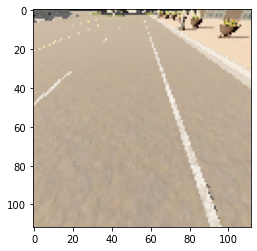

In [36]:
plt.imshow(showed_image)

In [37]:
img = imread(img_x_path)
img = img/255.0
img = img.reshape([1,112,112,3])

In [38]:
result = autoencoder.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


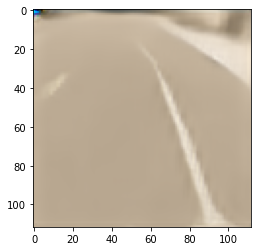

In [39]:
plt.imshow(result.reshape([112,112,3]))

# Building the motor babbling MLP

In [20]:
autoencoder.load_weights("/home/houcem/Documents/Models/autoencoder_babbling_sigmoid_regularized.h5") 

In [54]:
autoencoder.trainable = False

In [40]:
latent_input = Input(shape=(128,))

motor_input = Input(shape=(2,))

babbling_input = Concatenate()([latent_input, motor_input])

z = Dense(512, activation = selu, activity_regularizer= keras.regularizers.l2(1e-4), kernel_initializer = keras.initializers.he_uniform())(babbling_input)
z = Dense(128, activation = 'sigmoid')(z)

babbling_mlp = Model(inputs = [latent_input, motor_input], outputs = z)

In [41]:
babbling_mlp.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 130)          0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          67072       concatenate[0][0]          

# Let's train it and see the results 

In [42]:
babbling_mlp.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate=1e-4))

In [43]:
train_X = encoder.predict(train_generator(path, batch_size), steps = train_sample_size/batch_size)

In [44]:
train_X = train_X[0:50000,:]

In [45]:
train_y = encoder.predict(train_y_generator(path, batch_size), steps = train_sample_size/batch_size)

In [46]:
train_y = train_y[0:50000, :]

In [47]:
import pickle

data = open("/home/houcem/data/motor_output.p", "rb+")
unpickler = pickle.Unpickler(data)
training = unpickler.load()
data.close()

In [48]:
training = np.asarray(training)

In [49]:
babbling_mlp.fit(x=[train_X, training], y= train_y, epochs=4)

Epoch 1/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0162
Epoch 2/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0020
Epoch 3/4
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0011
Epoch 4/4
1563/1563 [==============================] - 2s 1ms/step - loss: 7.3138e-04


In [50]:
img_input = Input(shape=(112, 112, 3), name = "img")
motor_input = Input(shape=(2,), name = "motor")

Encoded = encoder([img_input])
babbling = babbling_mlp([Encoded, motor_input])
Decoded = Decoder(babbling)

babbling_model = Model(inputs = [img_input, motor_input], outputs = Decoded)

# Let's finetune the entire model

In [299]:
encoder.trainable = False

In [51]:
babbling_model.compile(loss = SSIM_l1_loss, optimizer = keras.optimizers.Adam(learning_rate = 1e-5))

In [52]:
babbling_model.fit(babbling_generator(train_csv_path, batch_size), steps_per_epoch= train_sample_size/batch_size, validation_data=babbling_generator(val_csv_path,batch_size), validation_steps=val_sample_size/batch_size, epochs = 15)

Epoch 1/15
2299/2298 [==============================] - 186s 81ms/step - loss: 0.5414 - val_loss: 0.3517
Epoch 2/15
2299/2298 [==============================] - 183s 80ms/step - loss: 0.4938 - val_loss: 0.3079
Epoch 3/15
2299/2298 [==============================] - 184s 80ms/step - loss: 0.4545 - val_loss: 0.2931
Epoch 4/15
2299/2298 [==============================] - 185s 80ms/step - loss: 0.4361 - val_loss: 0.2845
Epoch 5/15
2299/2298 [==============================] - 184s 80ms/step - loss: 0.4242 - val_loss: 0.2800
Epoch 6/15
2299/2298 [==============================] - 184s 80ms/step - loss: 0.4156 - val_loss: 0.2766
Epoch 7/15
2299/2298 [==============================] - 184s 80ms/step - loss: 0.4084 - val_loss: 0.2730
Epoch 8/15
2299/2298 [==============================] - 186s 81ms/step - loss: 0.4027 - val_loss: 0.2709
Epoch 9/15
2299/2298 [==============================] - 185s 80ms/step - loss: 0.3980 - val_loss: 0.2702
Epoch 10/15
2299/2298 [==============================] 

In [53]:
babbling_model.save_weights("Model_v3.h5")

In [33]:
babbling_model.load_weights("babbling_model_direct_adam.h5")

ValueError: Layer #1 (named "model_10" in the current model) was found to correspond to layer model_6 in the save file. However the new layer model_10 expects 6 weights, but the saved weights have 4 elements.

In [36]:
x_paths = sorted(glob.glob("/home/houcem/data_val/rgb/*.png"))

In [37]:
def display_results(x_paths, training, predictions, i):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(10,18))
    
    #Showing the image at instant t
    img_t = imread(str(x_paths[i]))
    ax.flat[0].imshow(img_t)
    
    #showing the image at instant t+1
    img_t1 = imread(str(x_paths[i+1]))
    ax.flat[1].imshow(img_t1)
    
    #showing the predicted image
    ax.flat[2].imshow(predictions[i])
    
    plt.show()
    
    print('Throttle ', training[i][0])
    print('Steering Angle', training[i][1])

In [38]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [39]:
interact(display_results, x_paths=fixed(x_paths), training=fixed(test), predictions=fixed(predictions), i=widgets.IntSlider(min=0, max=9999, step=1, value=10))

NameError: name 'test' is not defined